In [12]:
import os
import random
import matplotlib.pyplot as plt
from skimage import io, color
from scipy.ndimage import gaussian_laplace
import warnings
warnings.filterwarnings("ignore")
import os
import random
import matplotlib.pyplot as plt
from skimage import io, color, feature
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import os

### Laplacian of Gaussian (LoG) method

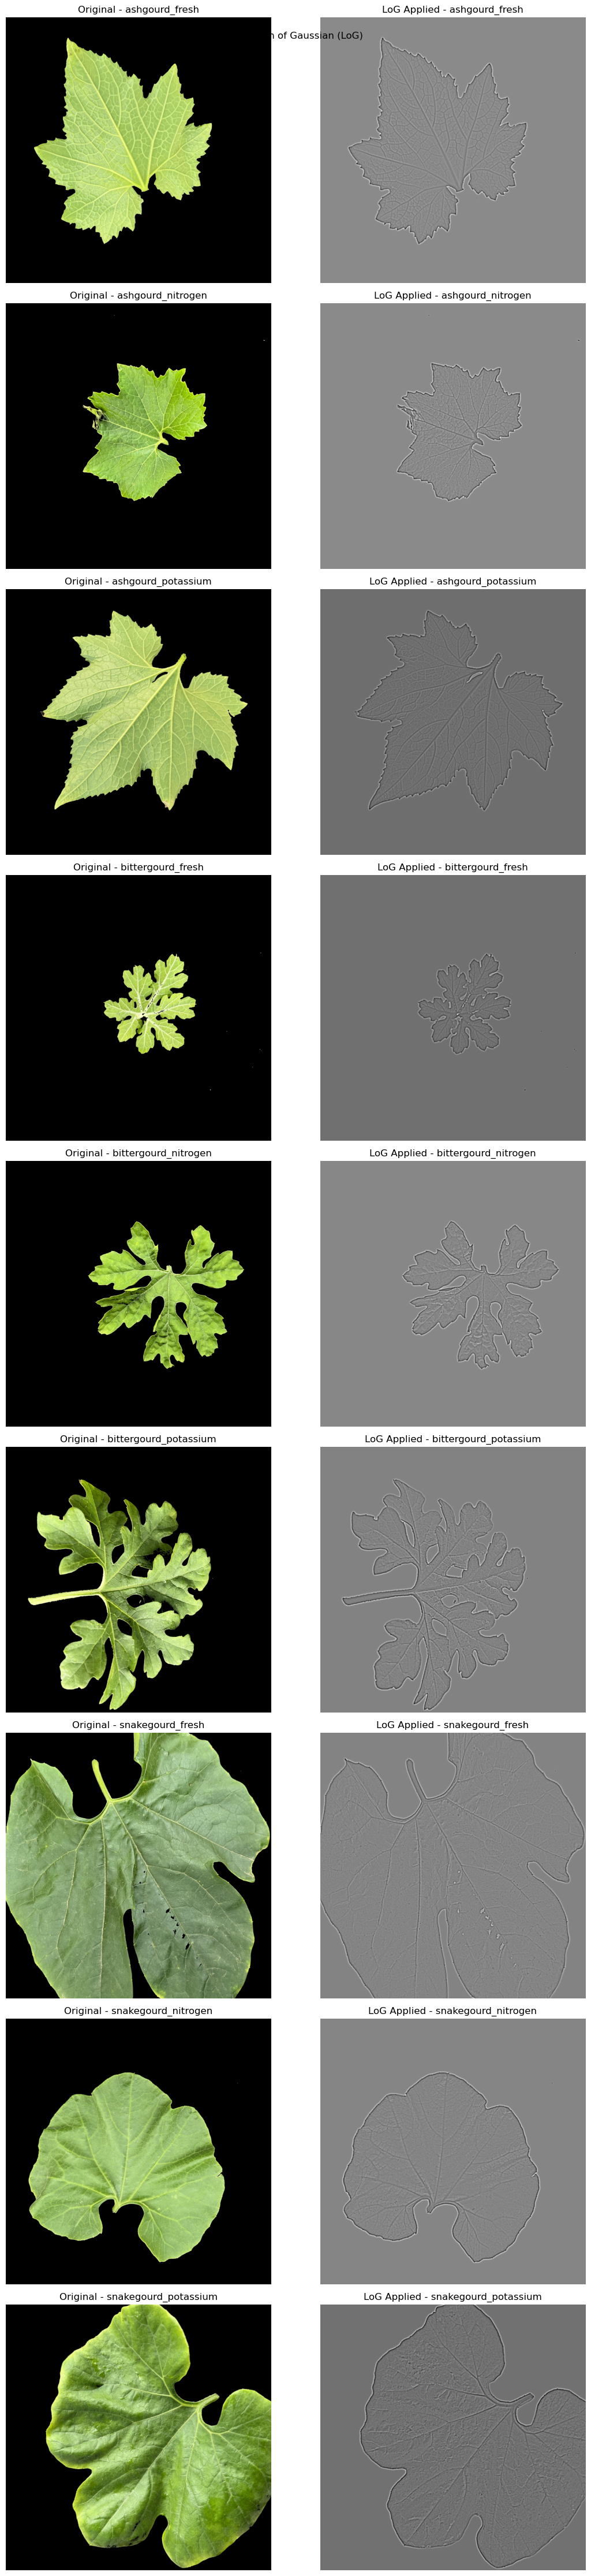

In [7]:
# Define the base directory
base_dir = "./Dataset"

# Function to apply LoG on an image
def apply_log(image_path, sigma=2):
    # Read and convert the image to grayscale
    image = io.imread(image_path)
    gray_image = color.rgb2gray(image)
    
    # Apply Laplacian of Gaussian
    log_image = gaussian_laplace(gray_image, sigma=sigma)
    
    # Normalize to make the result easier to visualize
    log_image = (log_image - log_image.min()) / (log_image.max() - log_image.min())
    
    return log_image

# Modified function to apply LoG and display samples from each class in the train set
def display_log_samples_per_class(base_dir, num_images=1, sigma=2):
    train_path = os.path.join(base_dir, 'train')
    classes = os.listdir(train_path)
    fig, axes = plt.subplots(len(classes), 2, figsize=(12, len(classes) * 5))
    
    for idx, class_name in enumerate(classes):
        class_path = os.path.join(train_path, class_name)
        image_files = os.listdir(class_path)
        
        # Sample a single image from each class
        sampled_image = random.choice(image_files)
        image_path = os.path.join(class_path, sampled_image)
        
        # Load original image and apply LoG
        original_image = io.imread(image_path)
        log_image = apply_log(image_path, sigma=sigma)
        
        # Display original and LoG-processed images side by side
        axes[idx, 0].imshow(original_image)
        axes[idx, 0].set_title(f"Original - {class_name}")
        axes[idx, 0].axis('off')
        
        axes[idx, 1].imshow(log_image, cmap='gray')
        axes[idx, 1].set_title(f"LoG Applied - {class_name}")
        axes[idx, 1].axis('off')
        
    plt.suptitle("Laplacian of Gaussian (LoG)")
    plt.tight_layout()
    plt.show()

# Display LoG processed images for a sample from each class
display_log_samples_per_class(base_dir, num_images=1, sigma=10)


### Edge detection method

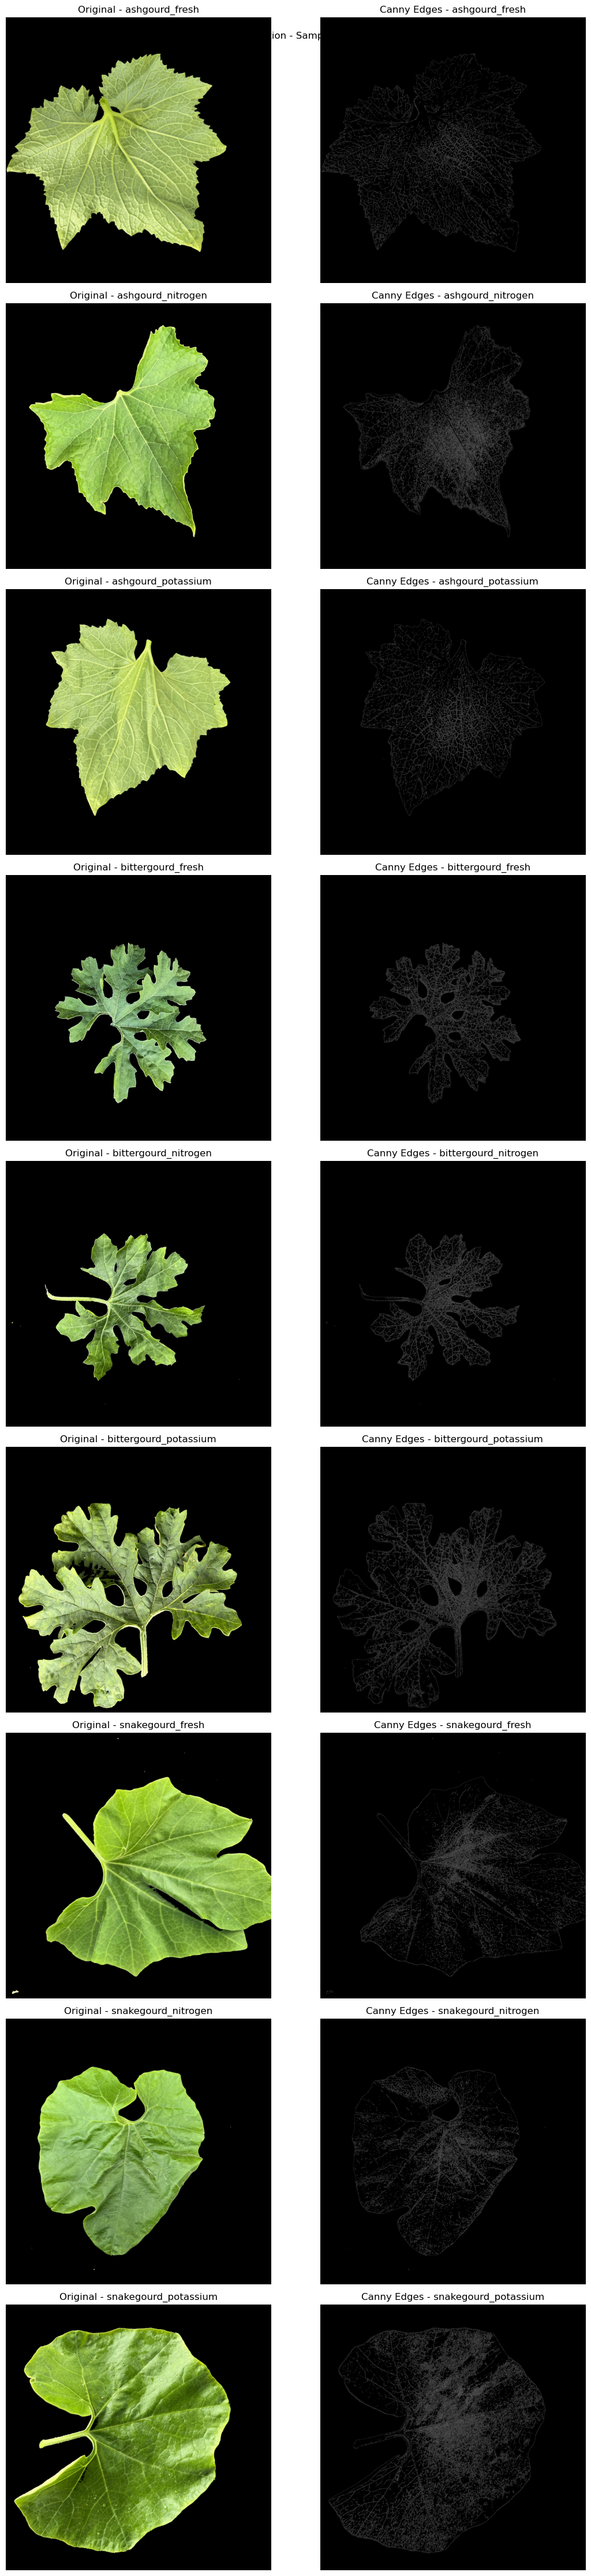

In [11]:
# Function to apply Canny edge detection on an image
def apply_canny(image_path, sigma=1.0):
    # Read and convert the image to grayscale
    image = io.imread(image_path)
    gray_image = color.rgb2gray(image)
    
    # Apply Canny edge detection
    edges = feature.canny(gray_image, sigma=sigma)
    return edges

# Function to display original and Canny edge-detected images for one sample from each class
def display_canny_samples_per_class(base_dir, sigma=1.0):
    train_path = os.path.join(base_dir, 'train')
    classes = os.listdir(train_path)
    fig, axes = plt.subplots(len(classes), 2, figsize=(12, len(classes) * 5))
    
    for idx, class_name in enumerate(classes):
        class_path = os.path.join(train_path, class_name)
        image_files = os.listdir(class_path)
        
        # Sample a single image from each class
        sampled_image = random.choice(image_files)
        image_path = os.path.join(class_path, sampled_image)
        
        # Load original image and apply Canny edge detection
        original_image = io.imread(image_path)
        edges = apply_canny(image_path, sigma=sigma)
        
        # Display original and edge-detected images side by side
        axes[idx, 0].imshow(original_image)
        axes[idx, 0].set_title(f"Original - {class_name}")
        axes[idx, 0].axis('off')
        
        axes[idx, 1].imshow(edges, cmap='gray')
        axes[idx, 1].set_title(f"Canny Edges - {class_name}")
        axes[idx, 1].axis('off')
        
    plt.suptitle("Canny Edge Detection - Sample from Each Class")
    plt.tight_layout()
    plt.show()

# Example usage (specify your base_dir where your dataset is located)
display_canny_samples_per_class(base_dir, sigma=1.0)

### Data augmentation

Found 1890 images belonging to 9 classes.
Found 405 images belonging to 9 classes.
Found 405 images belonging to 9 classes.


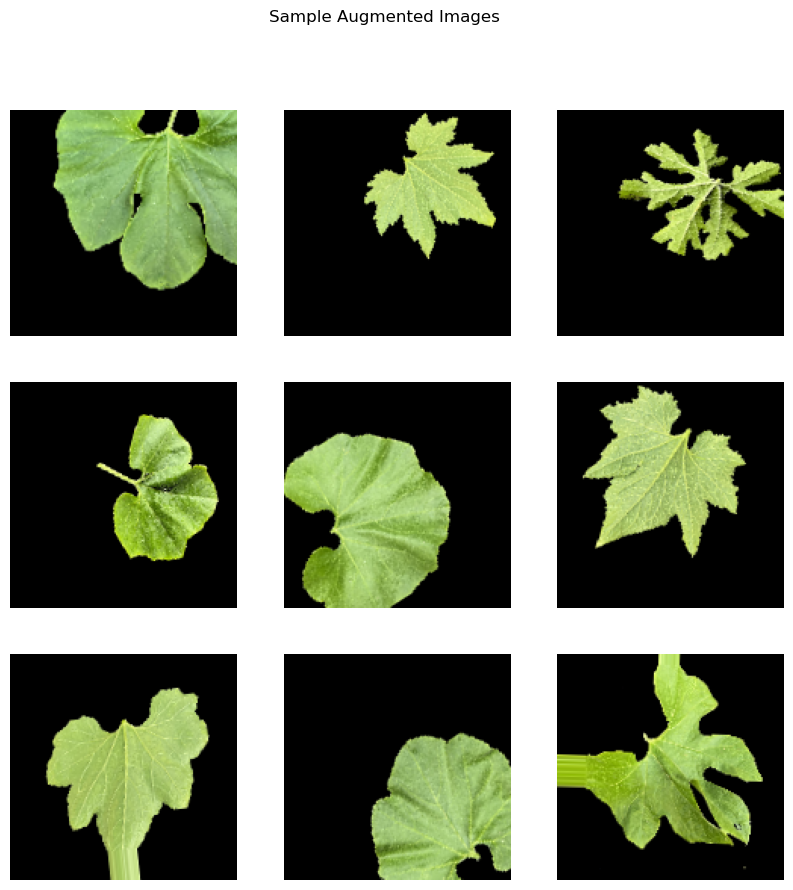

In [13]:
# Set up directories
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Data Augmentation and Data Generators
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=40,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

# Display some augmented images
def display_augmented_images(generator):
    images, labels = next(generator)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.suptitle("Sample Augmented Images")
    plt.show()

# Display augmented images from the training set
display_augmented_images(train_generator)

### Sample CNN model

In [16]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(len(train_generator.class_indices), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 4: Train the Model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=val_generator,
    validation_steps=len(val_generator)
)

Epoch 1/20
60/60 [==============================] - 557s 9s/step - loss: 2.0216 - accuracy: 0.1772 - val_loss: 1.7573 - val_accuracy: 0.2691
Epoch 2/20
60/60 [==============================] - 529s 9s/step - loss: 1.6003 - accuracy: 0.2899 - val_loss: 1.7229 - val_accuracy: 0.3235
Epoch 3/20
60/60 [==============================] - 524s 9s/step - loss: 1.4778 - accuracy: 0.3529 - val_loss: 1.4029 - val_accuracy: 0.3531
Epoch 4/20
60/60 [==============================] - 517s 9s/step - loss: 1.4480 - accuracy: 0.3545 - val_loss: 1.3770 - val_accuracy: 0.4222
Epoch 5/20
60/60 [==============================] - 518s 9s/step - loss: 1.3425 - accuracy: 0.4011 - val_loss: 1.8229 - val_accuracy: 0.3407
Epoch 6/20
60/60 [==============================] - 519s 9s/step - loss: 1.2630 - accuracy: 0.4503 - val_loss: 1.3069 - val_accuracy: 0.4642
Epoch 7/20
60/60 [==============================] - 518s 9s/step - loss: 1.2070 - accuracy: 0.4799 - val_loss: 1.6169 - val_accuracy: 0.4123
Epoch 8/20
60

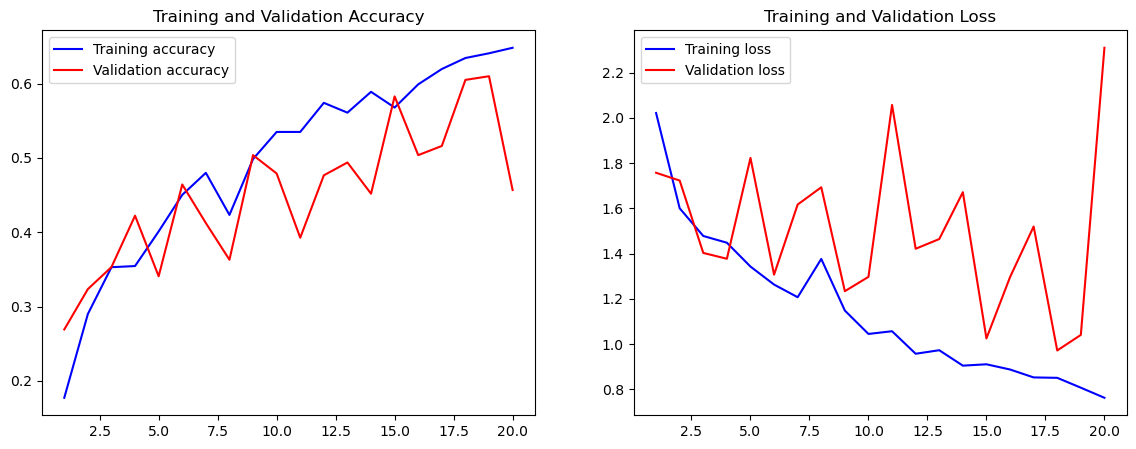

13/13 [==============================] - 93s 7s/step - loss: 2.4254 - accuracy: 0.4198
Test Accuracy: 0.42


In [17]:
# Step 5: Plot Learning Curves
def plot_learning_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)
    
    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    plt.show()

# Display the learning curves
plot_learning_curves(history)

# Step 6: Evaluate the Model on the Test Set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2f}")

In [18]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import os

# Load InceptionResNetV2 model with pre-trained ImageNet weights, without the top layer
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the base model layers to retain pre-trained features
base_model.trainable = False

# Add custom layers on top of the pre-trained model
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(len(train_generator.class_indices), activation='softmax')(x)

# Complete model with InceptionResNetV2 base and custom classification head
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with fine-tuning
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(val_generator)
)

219055592/219055592 [==============================] - 27s 0us/step
Epoch 1/10
60/60 [==============================] - 544s 9s/step - loss: 1.8050 - accuracy: 0.4026 - val_loss: 1.1699 - val_accuracy: 0.4840
Epoch 2/10
60/60 [==============================] - 522s 9s/step - loss: 1.2287 - accuracy: 0.4894 - val_loss: 1.1114 - val_accuracy: 0.5037
Epoch 3/10
60/60 [==============================] - 517s 9s/step - loss: 1.1384 - accuracy: 0.5185 - val_loss: 1.0258 - val_accuracy: 0.5259
Epoch 4/10
60/60 [==============================] - 520s 9s/step - loss: 1.0779 - accuracy: 0.5360 - val_loss: 0.9188 - val_accuracy: 0.5852
Epoch 5/10
60/60 [==============================] - 517s 9s/step - loss: 1.0151 - accuracy: 0.5603 - val_loss: 0.9707 - val_accuracy: 0.5753
Epoch 6/10
60/60 [==============================] - 519s 9s/step - loss: 0.9939 - accuracy: 0.5598 - val_loss: 0.9069 - val_accuracy: 0.5802
Epoch 7/10
60/60 [==============================] - 516s 9s/step - loss: 0.9626 - accu

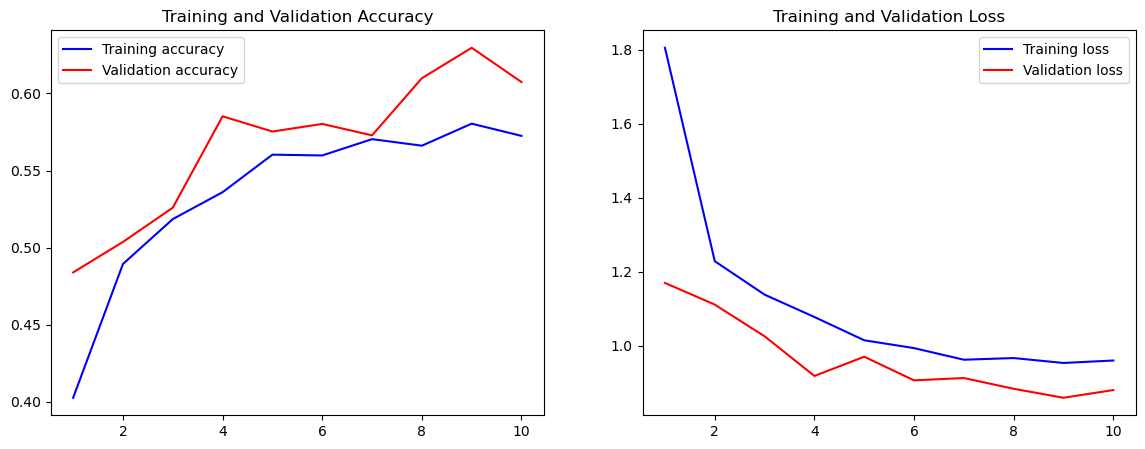

13/13 [==============================] - 91s 7s/step - loss: 0.8203 - accuracy: 0.6370
Test Accuracy: 0.64


In [19]:
# Plot fine-tuning learning curves
plot_learning_curves(history)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2f}")